In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
import joblib
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample
import scikitplot as skplt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_squared_error
random_state = 42

c:\Users\Piotr\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Model and data loading

In [2]:
def df_cleaning(df):
    '''initial preprocessing of insurance dataset'''
    print('1. All duplicated rows within dataset will be dropped. Found:', df.duplicated().sum(), 'duplicated rows.')
    df = df.drop_duplicates()
    print('2. All missing values within dataset will be replaced with 0. Found:', df.isna().sum().sum(), 'missing values. ')
    df = df.fillna(value=0)
    df = pd.get_dummies(df, drop_first=True)
    new_cols = [col for col in df.columns if col != 'charges'] + ['charges']
    df = df[new_cols]
    return df


def plot_feature_importances(model, feat_list):
    model_name = type(model).__name__
    skplt.estimators.plot_feature_importances(model, feature_names=df[feat_list].columns,
                                            title=f'{model_name} feature importances')
    plt.xticks(rotation=90)

def reg_metrics(y_true,y_pred):
    R2=r2_score(y_true, y_pred)
    MAE=mean_absolute_error(y_true, y_pred)
    MSE=mean_squared_error(y_true, y_pred)
    RMSE=mean_squared_error(y_true, y_pred, squared=False)
    # print('\nR2: {:.3f}\nMAE: {:.3f}\nMSE: {:.3f}'.format(R2,MAE,MSE))
    return R2,MAE,MSE,RMSE

def final_metric(model,y_test, y_pred):
    column_names=['model','R2-train','R2-test','MAE','MSE','RMSE']
    R2,MAE,MSE,RMSE=reg_metrics(y_test, y_pred)
    result=pd.DataFrame([[type(model).__name__,model.score(X_train.values, y_train.values),model.score(X_test.values, y_test.values),MAE,MSE,RMSE]],columns=column_names)
    result['MAE']=result['MAE'].astype(dtype=int)
    result['MSE']=result['MSE'].astype(dtype=int)
    result['RMSE']=result['RMSE'].astype(dtype=int)
    result=result.round({'R2-train':2})
    result=result.round({'R2-test':2})
    return result

In [3]:
df = pd.read_csv('../data/insurance.csv')
df=df_cleaning(df)
target=df.pop("charges")
data = df
random_state=42
X_train, X_test, y_train, y_test = train_test_split(data, target,test_size=0.33, random_state=random_state)

1. All duplicated rows within dataset will be dropped. Found: 1 duplicated rows.
2. All missing values within dataset will be replaced with 0. Found: 0 missing values. 


In [4]:
model = joblib.load('joblib_model_xgb_best_2')

In [5]:
y_pred=model.predict(X_test)

## Charts

### Feature Importance

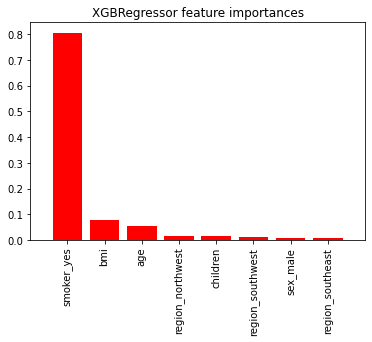

In [6]:
plot_feature_importances(model,X_test.columns)

### XGB - optimized

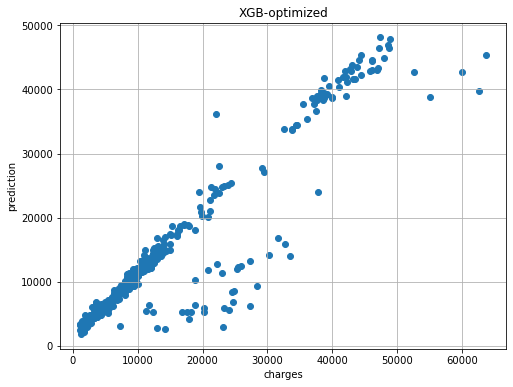

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(y_test,y_pred)
plt.title('XGB-optimized')
plt.xlabel('charges')
plt.ylabel('prediction')
plt.grid()
plt.show
plt.savefig('xgb_optimized.png',dpi=200)


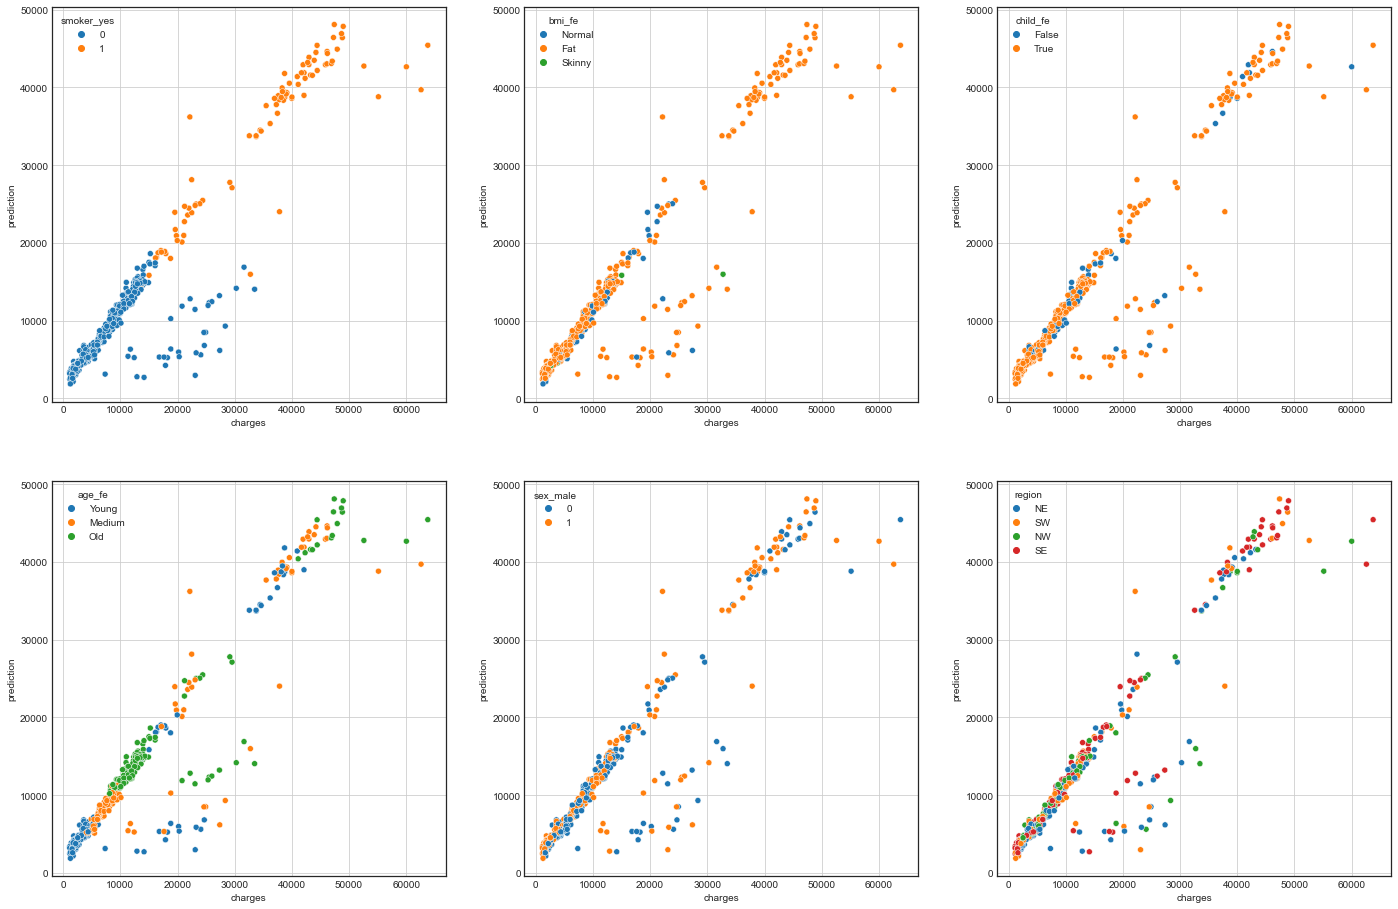

In [8]:
df_new=X_test.copy()
df_new['charges']=y_test
df_new['prediction']=y_pred
df_new['region']=np.zeros(len(df_new)).astype('object')
# df_new['region']=df_new['region'].astype('object')


for index, row in df_new.iterrows():
    if df_new.loc[index, 'region_northwest'] == 1:
        df_new.loc[index, 'region'] = 'NW'
    elif df_new.loc[index, 'region_southeast'] == 1:
        df_new.loc[index, 'region'] = 'SE'
    elif df_new.loc[index, 'region_southwest'] == 1:
        df_new.loc[index, 'region'] = 'SW'
    else:
        df_new.loc[index, 'region'] = 'NE'

def obese(col):
    if col > 25:
        return 'Fat'
    # elif col <= 30 and col > 25:
    #     return 'Fat'
    elif col <= 25 and col > 18.5:
        return 'Normal'
    else:
        return 'Skinny'
df_new['bmi_fe'] = df_new['bmi'].apply(obese)

df_new['child_fe'] = df_new['children'] < 3

labels = 'Young', 'Medium', 'Old'
df_new['age_fe'] = pd.qcut(df_new['age'], len(labels), labels=labels)

plt.figure(figsize = (24, 16))
plt.style.use('seaborn-white')

plt.subplot(231)
sns.scatterplot(x="charges", y="prediction",hue="smoker_yes", data=df_new)
plt.grid()
plt.subplot(232)
sns.scatterplot(x="charges", y="prediction",hue="bmi_fe", data=df_new)
plt.grid()
plt.subplot(233)
sns.scatterplot(x="charges", y="prediction",hue="child_fe", data=df_new)
plt.grid()
plt.subplot(234)
sns.scatterplot(x="charges", y="prediction",hue="age_fe", data=df_new)
plt.grid()
plt.subplot(235)
sns.scatterplot(x="charges", y="prediction",hue="sex_male", data=df_new)
plt.grid()
plt.subplot(236)
sns.scatterplot(x="charges", y="prediction",hue="region", data=df_new);
plt.grid()
plt.savefig('predictions_horizontal.png',dpi=200)

### vertical

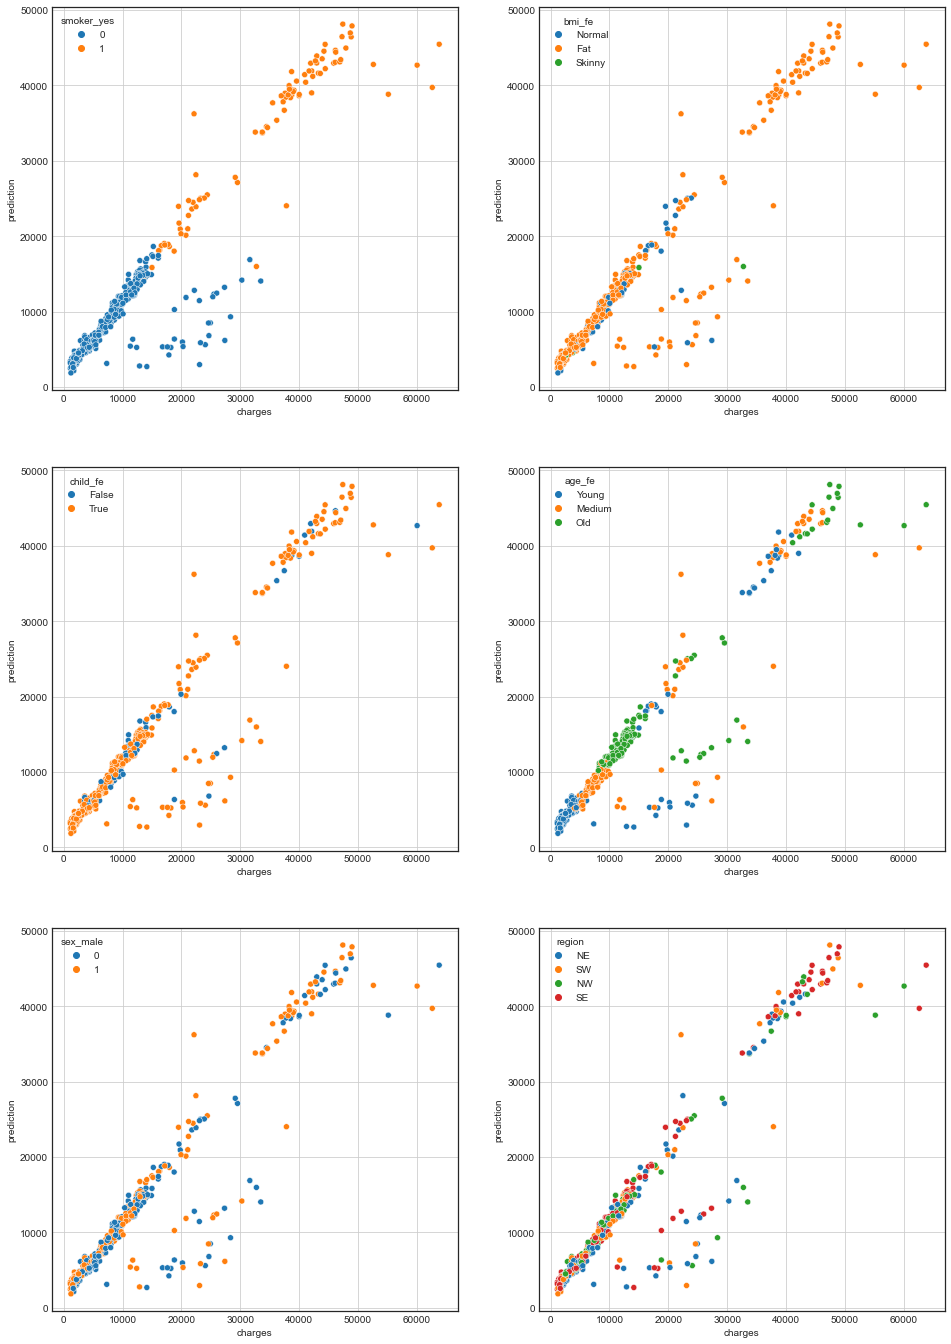

In [9]:
plt.figure(figsize = (16, 24))
plt.style.use('seaborn-white')
plt.subplot(321)
sns.scatterplot(x="charges", y="prediction",hue="smoker_yes", data=df_new)
plt.grid()
plt.subplot(322)
sns.scatterplot(x="charges", y="prediction",hue="bmi_fe", data=df_new)
plt.grid()
plt.subplot(323)
sns.scatterplot(x="charges", y="prediction",hue="child_fe", data=df_new)
plt.grid()
plt.subplot(324)
sns.scatterplot(x="charges", y="prediction",hue="age_fe", data=df_new)
plt.grid()
plt.subplot(325)
sns.scatterplot(x="charges", y="prediction",hue="sex_male", data=df_new)
plt.grid()
plt.subplot(326)
sns.scatterplot(x="charges", y="prediction",hue="region", data=df_new);
plt.grid()
plt.savefig('predictions_vertical.png',dpi=200)

### Basic models - metric comparison

In [15]:
basic_models_metrics=pd.read_csv('../basic_models_metric.csv',index_col=[0])
basic_models_metrics
dfi.export(basic_models_metrics, 'basic_models_metrics.png')

### Final model metric

In [18]:
import dataframe_image as dfi
a=final_metric(model,y_test, y_pred)
dfi.export(a, 'final_metric.png')